# Machine Learning Engineer Nanodegree
# Lin Muqing
# Capstone Model Iteration

In [3]:
import warnings
from imp import reload
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle as pkl
from IPython.display import display

%matplotlib inline

In [4]:
import data_prep
import models
import features
import cross_validation
import lgb_models
import cat_boost_models

In [3]:
reload(models)
reload(features)
reload(cross_validation)

<module 'cross_validation' from 'E:\\udacityMLND\\projects\\capstone\\project_submit\\cross_validation.py'>

## Prep Runnings

The following code generates all needed local files, including parameter search, engineering for class 3 features, model submission, each model's CV results. Output are stored at local, and following analysis and demonstrations directly read those files. I would also commit all those files to Git, reader can directly take a look at that for full information. It is not recommanded to run the following code again, it would take a looooooooong time. 

Files are located at:
- param_search/ for parameter search results.
- models/ for individual model cv results.
- class3_search/ for class 3 features search results.

In [4]:
# lgb_models.param_search_raw()
# lgb_models.param_search_one_step()
# lgb_models.param_search_step2()
# cat_boost_models.param_search()

# features.class_3_feature_search()

mlist = [models.ModelMedian(),
         models.ModelLGBRaw(),
         models.ModelLGBRawSubCol(),
         models.ModelLGBRawIncMon(),
         models.ModelLGBRawIncMonOutlierRm(),
         models.ModelLGBOneStep(),
         models.ModelLGBOneStepDefaultParam(),
         models.ModelLGBBlendingOneStep(),
         models.ModelLGBTwoStep(),
         models.ModelLGBTwoStepBlending(),
         models.ModelCatBoost(),
         models.ModelCatBoostDefaultParam(),
         models.ModelCatBoostBlending(),
         models.ModelDirectBlendingLGB(),
         models.ModelDirectBlendingAll()]

# for m in mlist:
#     m.submit()
    
# # do the manual submission to Kaggle, and copy down scores to code
# for m in mlist:
#     format_cv_output(m)

## Parameter Search

Quick demonstration of parameter search results.

### LightGBM raw

I picked the thrid one, as it is inital research and I want to keep the number-iterations low to make this run faster.

In [5]:
search_res = pd.read_csv('param_search/lgb_random_raw.csv')
display(search_res.iloc[:10, :])

,l1-mean,l1-stdv,n_rounds,num_leaves,min_data_in_leaf,learning_rate
0,0.067906,0.000259,10775,35,135,0.002373
1,0.067908,0.000263,10785,44,147,0.001895
2,0.067909,0.000271,2235,76,168,0.006207
3,0.067910,0.000262,4661,54,167,0.004100
4,0.067911,0.000270,10939,74,192,0.001252
5,0.067914,0.000250,675,53,110,0.027988
6,0.067916,0.000269,3089,48,163,0.006707
7,0.067917,0.000270,7403,69,231,0.002103
8,0.067920,0.000272,12000,72,260,0.001035
9,0.067923,0.000269,10775,60,285,0.001539


### LightGBM one step

I picked lines 1, 2, 3, 4, 6. Line 5 is passed as r_rounds == 12000 meaning the model has not been sufficiently trained. Again, to sufficiently train it, using it would take too long.

In [6]:
search_res = pd.read_csv('param_search/lgb_random_1step.csv')
display(search_res.iloc[:10, :])

,l1-mean,l1-stdv,n_rounds,num_leaves,min_data_in_leaf,learning_rate
0,0.056798,0.000377,7315,78,323,0.002880
1,0.056801,0.000378,7289,77,296,0.002755
2,0.056802,0.000371,9520,69,231,0.002103
3,0.056804,0.000374,7431,73,333,0.002732
4,0.056804,0.000380,12000,79,417,0.001402
5,0.056806,0.000378,7604,75,461,0.002726
6,0.056806,0.000380,8319,79,449,0.002506
7,0.056807,0.000380,8885,39,402,0.004042
8,0.056807,0.000373,3520,76,168,0.006207
9,0.056807,0.000377,12000,61,498,0.001764


### CatBoost

CatBoost can be really slow when number of rounds is too high, I picked the second one.

In [7]:
search_res = pd.read_csv('param_search/catboost_random.csv')
display(search_res.iloc[:10, :])

,MAE_avg,MAE_stddev,n_iter,learning_rate,depth,l2_leaf_reg
0,0.056822,0.000437,1717,0.019281,5,4
1,0.056833,0.000456,1186,0.017289,6,7
2,0.056840,0.000442,1215,0.017868,6,7
3,0.056843,0.000442,1069,0.019414,5,7
4,0.056845,0.000434,961,0.021145,6,8
5,0.056845,0.000438,1183,0.016247,6,5
6,0.056852,0.000437,886,0.016978,7,7
7,0.056858,0.000455,821,0.028395,5,8
8,0.056867,0.000463,753,0.028152,5,8
9,0.056870,0.000457,734,0.026577,5,7


## Seasonality Effect

From LightGBM Raw model, there exists in-sample bias in each month group, which makes necessary to include sale_month as predictor. For CV purpose, I choose the quarter with consistent and obvious bias effect, that is month 4, 5, 6. 

In [8]:
# choose seasonality CV target months
m = models.ModelLGBRaw()
m.train(data_prep.train_x, data_prep.train_y, True, True)
is_pred_y = m.predict(data_prep.train_x)
y_diff = data_prep.train_y - is_pred_y
y_diff_group_med = y_diff.groupby(data_prep.train_x['sale_month']).median()
display(y_diff_group_med)

sale_month
1     0.003094
2     0.001182
3    -0.002469
4    -0.002611
5    -0.001735
6    -0.001040
7     0.000063
8     0.000929
9     0.003060
10    0.003365
11    0.003897
12    0.002919
Name: logerror, dtype: float64

## Extreme Value Boundary

I pick the top 0.5% and bottom 0.5% y values as outlier, and fix the values for CV and prediction consistency. 

In [9]:
outlier_frac = 0.01
upper_bound = np.percentile(data_prep.train_y, (1 - outlier_frac / 2) * 100)
lower_bound = np.percentile(data_prep.train_y, outlier_frac / 2 * 100)
print('outlier upper bound: %.4f' % upper_bound)
print('outlier lower bound: %.4f' % lower_bound)

outlier upper bound: 0.7566
outlier lower bound: -0.4865


## Feature Importance of Raw Model

We found some class 4 features rank high (e.g. area_living_type_15) and some class 1 features rank low (e.g. code fips), which explains why manual feature selection works worse than the raw model.

In [10]:
model_lgb_raw_model = pkl.load(open('models/model_lgb_raw.pkl', 'rb'))
feature_info = features.feature_importance(model_lgb_raw_model)
feature_info = feature_info[['features', 'class', 'avg_rank', 'split_rank', 'gain_rank']]
pd.options.display.float_format = '{:,.2f}'.format
display(feature_info)

,features,class,avg_rank,split_rank,gain_rank
0,area_lot,1,1.50,1,2
1,area_living_finished_calc,1,1.50,2,1
2,dollar_taxvalue_structure,1,4.00,5,3
3,latitude,1,4.00,4,4
4,year_built,1,4.00,3,5
5,longitude,1,7.00,7,7
6,dollar_tax,1,7.00,8,6
7,code_zip_lgb,3,8.00,6,10
8,dollar_taxvalue_land,1,8.50,9,8
9,dollar_taxvalue_total,1,9.50,10,9


## Model Performance

Summarization of all CV results.

In [11]:
pd.options.display.float_format = '{:,.7f}'.format
df = None
for m in mlist:
    df_m = pd.read_csv('models/cv_res_%s.csv' % m.label, index_col=0)
    if df is None:
        df = df_m
    else:
        df = pd.concat([df, df_m], axis=0)
df.index = [m.label for m in mlist]
display(df)
df.to_csv('models/cv_res_all.csv', float_format='%.7f')

,cv_avg,cv_public_LB,cv_private_LB,score_public_LB,rank_public_LB,score_private_LB,rank_private_LB
median,0.0688602,0.0686197,0.0670265,0.0653607,3257,0.0763265,2839
lgb_raw,0.0678963,0.0680460,0.0660475,0.0643716,763,0.0752874,501
lgb_raw_sub_col,0.0680005,0.0681183,0.0661133,0.0644800,1406,0.0753710,680
lgb_raw_inc_mon,0.0678253,0.0678715,0.0659177,0.0641573,232,0.0750084,81
lgb_raw_inc_mon_outlier_rm,0.0678244,0.0678784,0.0659268,0.0641336,181,0.0749581,58
lgb_1step,0.0677833,0.0678285,0.0658481,0.0641632,242,0.0749579,58
lgb_1step_default_param,0.0681107,0.0680642,0.0661284,0.0643160,563,0.0752334,435
lgb_1step_blending,0.0677464,0.0678076,0.0658115,0.0641527,225,0.0749282,50
lgb_2step,0.0000000,0.0679743,0.0659063,0.0641599,236,0.0749253,49
lgb_2step_blending,0.0000000,0.0679547,0.0659018,0.0641384,192,0.0749144,44


## Residual Analysis

With best performing model, pick several features, use residual plot to show is-sample patterns has been well modeled. 

In [8]:
# mlist = [models.ModelLGBBlendingOneStep(),
#          models.ModelLGBTwoStepBlending(),
#          models.ModelCatBoostBlending()]
# mweight = [1.0, 1.0, 2.0]
# for m in mlist:
#     m.model = pkl.load(open('models/model_' + m.label + '.pkl', 'rb'))

# is_pred = None
# for idx, m in enumerate(mlist):
#     pred = m.predict(data_prep.train_x) * mweight[idx]
#     if is_pred is None:
#         is_pred = pred
#     else:
#         is_pred += pred
# is_pred /= sum(mweight)

# pkl.dump(is_pred, open('models/blending_all_in_sample_pred.pkl', 'wb'))
is_pred = pkl.load(open('models/blending_all_in_sample_pred.pkl', 'rb'))

In [25]:
import seaborn as sns
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

pred_diff = data_prep.train_y - is_pred
orig_tar = data_prep.train_y.values

def visual_residual_num(col_name):
    """view relationship to error for numerical variables, summarize for NaN separately"""
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, sharey=ax1)
    train_col_values = data_prep.train_x[col_name].values
    up_thresh =  np.percentile(train_col_values[~np.isnan(train_col_values)], 99.5)
    down_thresh = np.percentile(train_col_values[~np.isnan(train_col_values)], 0.5)
    keep_idx = np.logical_and(train_col_values < up_thresh, train_col_values > down_thresh)
    
    fit_logerror = lowess(orig_tar[keep_idx], train_col_values[keep_idx], return_sorted =False, it=0)
    sns.regplot(train_col_values[keep_idx], fit_logerror, fit_reg=False, ax=ax1).set_title('against orig_target')
    fit_residual = lowess(pred_diff[keep_idx], train_col_values[keep_idx], return_sorted =False, it=0)
    sns.regplot(train_col_values[keep_idx], fit_residual, fit_reg=False, ax=ax2).set_title('against residual')
    fig.suptitle('residual analysis for %s' % col_name)
    fig.show()
    fig.savefig('figs/residual_%s.png' % col_name)

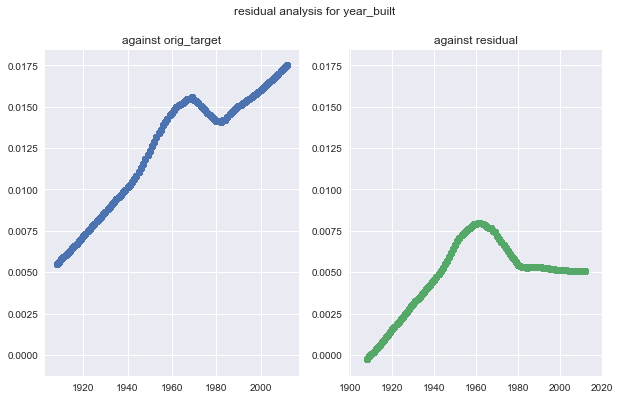

In [26]:
visual_residual_num('year_built')

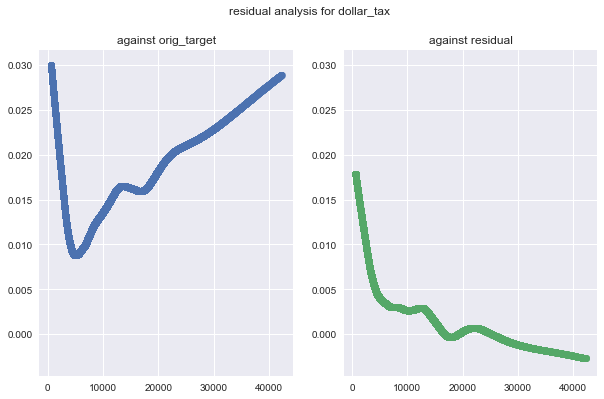

In [27]:
visual_residual_num('dollar_tax')

### direct analysis of residuals of months

In [28]:
# choose seasonality CV target months
pred_diff_series = pd.Series(pred_diff, index=data_prep.train_y.index)
orig_tar_group_med = data_prep.train_y.groupby(data_prep.train_x['sale_month']).median()
orig_tar_group_med.sort_index(inplace=True)
residual_group_med = pred_diff_series.groupby(data_prep.train_x['sale_month']).median()
residual_group_med.sort_index(inplace=True)
df = pd.DataFrame({'orig_tar': orig_tar_group_med.values, 'residual': residual_group_med}, index=orig_tar_group_med.index.values)
df.to_csv('models/mon_residual_analysis.csv')
display(df)

,orig_tar,residual
1,0.010157,-0.000377
2,0.007988,-0.000598
3,0.002207,-0.001766
4,0.002335,-0.001806
5,0.003502,-0.001252
6,0.004120,-0.001219
7,0.006594,-0.001047
8,0.008000,-0.000955
9,0.010900,-0.000596
10,0.010900,-0.000400
